# Analyzing Trimmed Mean Ratio 

Goal: 
Isolate trades that are out of character for a given representative

Analysis Plan:
1. Calculate trimmed mean for each representative, with trimmed mean 

        - Trimmed mean: the mean of all values in the sample excluding the top and bottom percentile (for this experiment we took out the top and bottom 5% of trades)
2. Divide each trade `Amount` by the `trimmed_mean` to get a ratio. This is to isolate trades that we deem out of the range, as outlier trades will have a significantly higher range.
3. Outlier ranges will be analyzed, and corroborated with variation and volume analyses

### Step 0: Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the data
df = pd.read_csv('congress_main.csv')
df.head()

,ReportDate,TransactionDate,Ticker,Representative,Transaction,Amount,Party,House,Range,Sentiment,Price,Low_End,High_End,Adjusted_Low_End,Adjusted_High_End,Running_Portfolio_Low_End,Running_Portfolio_High_End,Est_Portfolio_Value,Shares_High_End,Shares_Low_End
0,2018-05-15,2018-03-05,WFC,A. Mitchell Jr. McConnell,Purchase,1001.0,R,Senate,1001 - 15000,NaN,49.059349,1001.0,15000.0,-1001.0,-15000.0,-3003.0,-45000.0,-24001.5,-305.752120,-20.403858
1,2018-06-13,2018-06-01,WFC,A. Mitchell Jr. McConnell,Purchase,1001.0,R,Senate,1001 - 15000,NaN,46.939678,1001.0,15000.0,-1001.0,-15000.0,-4004.0,-60000.0,-32002.0,-319.559072,-21.325242
2,2018-09-14,2018-09-06,WFC,A. Mitchell Jr. McConnell,Purchase,1001.0,R,Senate,1001 - 15000,NaN,50.084381,1001.0,15000.0,-1001.0,-15000.0,-5005.0,-75000.0,-40002.5,-299.494566,-19.986271
3,2019-03-06,2019-03-05,WFC,A. Mitchell Jr. McConnell,Purchase,1001.0,R,Senate,1001 - 15000,NaN,43.876400,1001.0,15000.0,-1001.0,-15000.0,-7007.0,-105000.0,-56003.5,-341.869433,-22.814087
4,2019-06-14,2019-06-03,VMC,A. Mitchell Jr. McConnell,Sale,250001.0,R,Senate,250001 - 500000,NaN,123.395256,250001.0,500000.0,250001.0,500000.0,241993.0,380000.0,310996.5,4052.019634,2026.017921


### Step 1: Calculating Trimmed Mean

In [31]:
# Group by 'Representative', and for each group, trim the top and bottom 5% of 'Amount' values
df_trimmed = df.groupby('Representative').apply(lambda group: group.loc[
    (group['Amount'] > group['Amount'].quantile(0.001)) & (group['Amount'] < group['Amount'].quantile(0.999))
])

# Reset index as the previous operation results in a MultiIndex
df_trimmed = df_trimmed.reset_index(drop=True)

# Now, group by 'Representative' again and calculate the mean of 'Amount' for each group
df_mean = df_trimmed.groupby('Representative')['Amount'].mean().reset_index()
# rename `Amount` to `Trimmed_Mean`
df_mean = df_mean.rename(columns={'Amount': 'Trimmed_Mean'})

**Problem:**
There is a lot of data lost in trimming the number of amounts used to calculate the mean as there might not be enough trades to examine for the given representative. This may not be a bad thing as there is no way for us to find fishy trades for certain representatives if they have limited number of reported trades

In [32]:
df_mean.head()
# find unique representatives
unique_representatives = len(df_mean['Representative'].unique())
print(f'trimmed data has {unique_representatives} unique representatives')

ogunique_representatives = len(df['Representative'].unique())
print(f'original data has {ogunique_representatives} unique representatives')


trimmed data has 85 unique representatives
original data has 214 unique representatives


### Step 2: Finding Ratio

In [33]:
# merge df_mean with df on 'Representative'
df_merged = pd.merge(df_mean, df, on='Representative', how='left')
# number of unique representatives in df_merged
merged_unique_representatives = len(df_merged['Representative'].unique())
print(f'merged data has {merged_unique_representatives} unique representatives')
df_merged.head()

merged data has 85 unique representatives


,Representative,Trimmed_Mean,ReportDate,TransactionDate,Ticker,Transaction,Amount,Party,House,Range,...,Price,Low_End,High_End,Adjusted_Low_End,Adjusted_High_End,Running_Portfolio_Low_End,Running_Portfolio_High_End,Est_Portfolio_Value,Shares_High_End,Shares_Low_End
0,Alan S. Lowenthal,745.581138,2018-05-09,2018-01-09,ADSK,Sale,1001.00,D,Representatives,1001-15000,...,112.110001,1001.00,15000.0,1001.00,15000.0,1001.00,15000.0,8000.500,133.797163,8.928731
1,Alan S. Lowenthal,745.581138,2018-05-03,2018-04-25,CHTR,Sale,299.14,D,Representatives,299.14,...,300.350006,299.14,NaN,299.14,NaN,1300.14,NaN,NaN,NaN,0.995971
2,Alan S. Lowenthal,745.581138,2018-05-03,2018-04-25,CHTR,Sale,1001.00,D,Representatives,1001-15000,...,300.350006,1001.00,15000.0,1001.00,15000.0,2301.14,30000.0,16150.570,49.941734,3.332778
3,Alan S. Lowenthal,745.581138,2018-05-03,2018-04-26,EFX,Purchase,231.65,D,Representatives,231.65,...,110.254707,231.65,NaN,-231.65,NaN,2069.49,NaN,NaN,NaN,-2.101044
4,Alan S. Lowenthal,745.581138,2018-05-03,2018-04-26,BMRN,Purchase,1001.00,D,Representatives,1001-15000,...,82.510002,1001.00,15000.0,-1001.00,-15000.0,1068.49,15000.0,8034.245,-181.796141,-12.131862


In [37]:
# create a new column that divides 'Amount' by the mean of 'Amount' for each representative
df_merged['Normalized_Amount'] = df_merged['Amount'] / df_merged['Trimmed_Mean']
# sort by 'Normalized_Amount'
df_merged = df_merged.sort_values(by='Normalized_Amount', ascending=False)
df_merged[['Representative', 'TransactionDate', 'Amount', 'Trimmed_Mean', 'Normalized_Amount']]

,Representative,TransactionDate,Amount,Trimmed_Mean,Normalized_Amount
11339,Kelly Loeffler,2020-02-18,5000001.00,83489.805970,59.887563
11586,Kelly Loeffler,2020-07-22,5000001.00,83489.805970,59.887563
11414,Kelly Loeffler,2020-03-11,5000001.00,83489.805970,59.887563
11584,Kelly Loeffler,2020-05-20,5000001.00,83489.805970,59.887563
11416,Kelly Loeffler,2020-03-11,5000001.00,83489.805970,59.887563
...,...,...,...,...,...
16753,Suzan K. Delbene,2020-06-30,1001.00,529167.666667,0.001892
16758,Suzan K. Delbene,2020-09-30,1001.00,529167.666667,0.001892
16749,Suzan K. Delbene,2019-09-30,1001.00,529167.666667,0.001892
16502,Susie Lee,2021-04-21,1.00,1001.000000,0.000999


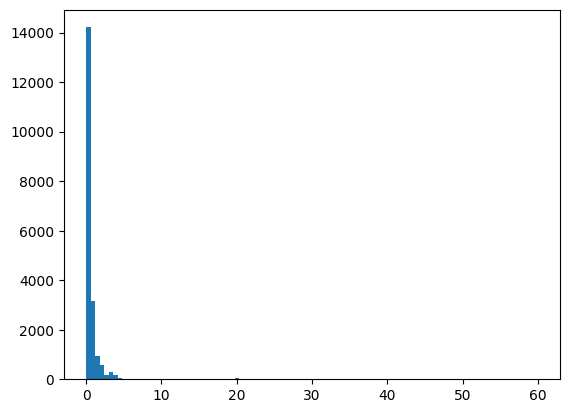

In [39]:
# plot the distribution of 'Normalized_Amount'
plt.hist(df_merged['Normalized_Amount'], bins=100)
plt.show()

lower bound: -3.183332804736864
upper bound: 5.376585464124929


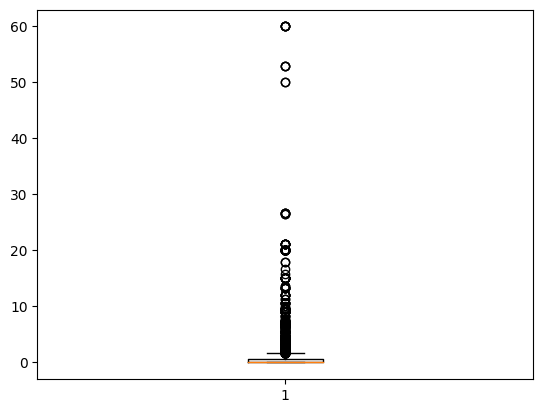

In [42]:
# find outliers of `Normalized_Amount` statistically using the IQR method
q1 = df_merged['Normalized_Amount'].quantile(0.05)
q3 = df_merged['Normalized_Amount'].quantile(0.95)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print(f'lower bound: {lower_bound}')
print(f'upper bound: {upper_bound}')

# find outliers of `Normalized_Amount` visually using a boxplot

plt.boxplot(df_merged['Normalized_Amount'])
plt.show()

In [43]:
# find representatives and transaction dates (aka trades) that are outliers
outliers = df_merged.loc[(df_merged['Normalized_Amount'] < lower_bound) | (df_merged['Normalized_Amount'] > upper_bound)]
outliers[['Representative', 'TransactionDate', 'Amount', 'Trimmed_Mean', 'Normalized_Amount']]



,Representative,TransactionDate,Amount,Trimmed_Mean,Normalized_Amount
11339,Kelly Loeffler,2020-02-18,5000001.0,83489.805970,59.887563
11586,Kelly Loeffler,2020-07-22,5000001.0,83489.805970,59.887563
11414,Kelly Loeffler,2020-03-11,5000001.0,83489.805970,59.887563
11584,Kelly Loeffler,2020-05-20,5000001.0,83489.805970,59.887563
11416,Kelly Loeffler,2020-03-11,5000001.0,83489.805970,59.887563
...,...,...,...,...,...
13368,Mr. Peter Meijer,2021-02-16,100001.0,18403.777778,5.433721
13336,Mr. Peter Meijer,2021-02-16,100001.0,18403.777778,5.433721
13323,Mr. Peter Meijer,2021-02-16,100001.0,18403.777778,5.433721
12165,Kim Schrier,2020-03-03,1000001.0,185715.285714,5.384592


In [49]:
# names of representatives that are outliers
outlier_names = outliers['Representative'].unique()
outlier_trades = {}
for name in outlier_names:
    outlier_trades[name] = outliers.loc[outliers['Representative'] == name]['TransactionDate'].tolist()
# sort dictionary by most items in value to least
outlier_trades = dict(sorted(outlier_trades.items(), key=lambda item: len(item[1]), reverse=True))
for name, trades in outlier_trades.items():
    print(f'{name}: {trades}')

Alan S. Lowenthal: ['2020-06-29', '2022-01-21', '2020-06-04', '2021-10-21', '2019-06-04', '2022-08-26', '2018-10-29', '2022-04-06', '2019-12-13', '2022-01-14', '2022-05-06', '2022-03-07', '2021-12-15', '2021-12-15', '2022-01-14', '2019-04-15', '2021-11-04', '2018-12-03', '2020-04-03', '2018-09-24', '2022-10-21', '2020-06-04', '2020-04-03', '2020-04-03', '2020-04-03', '2018-12-03', '2020-03-20', '2020-02-19', '2020-03-09', '2018-11-20', '2019-05-23', '2018-11-29', '2021-08-23', '2019-12-11', '2021-01-27', '2021-02-25', '2019-10-08', '2021-02-01', '2020-11-09', '2021-02-22', '2021-02-22', '2018-07-20', '2021-03-10', '2020-11-09', '2018-05-04', '2020-11-23', '2021-06-03', '2020-11-23', '2022-11-04', '2018-04-27', '2021-07-08', '2020-10-28', '2020-10-15', '2020-11-09', '2021-08-23', '2020-12-28', '2019-10-31', '2022-12-09', '2019-08-20', '2021-08-23', '2021-03-15', '2020-11-10', '2020-08-06', '2019-11-04']
Susie Lee: ['2019-01-11', '2022-01-27', '2020-07-08', '2022-01-27', '2020-08-25', '2

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


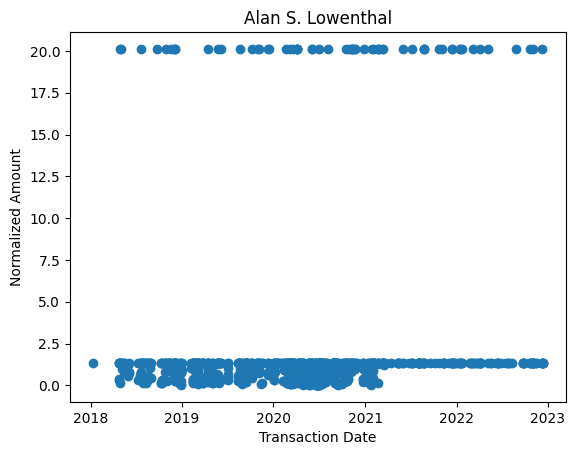

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


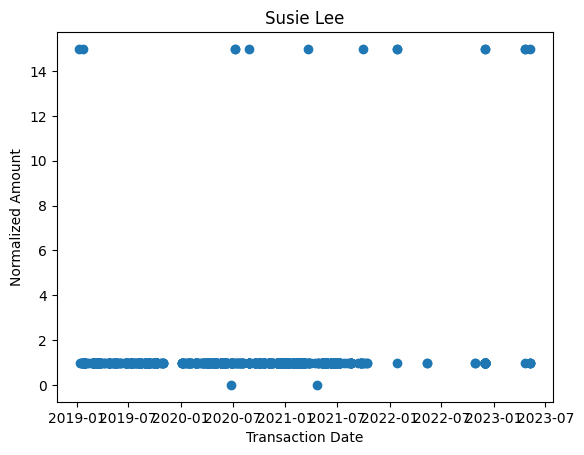

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


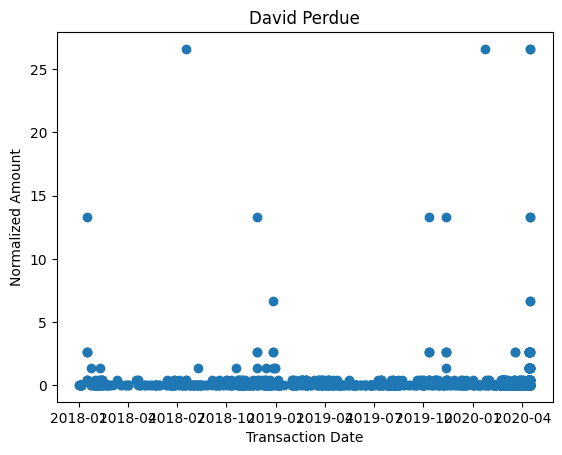

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


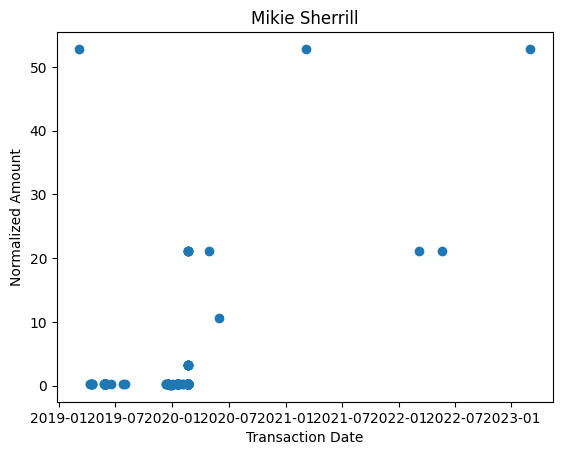

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


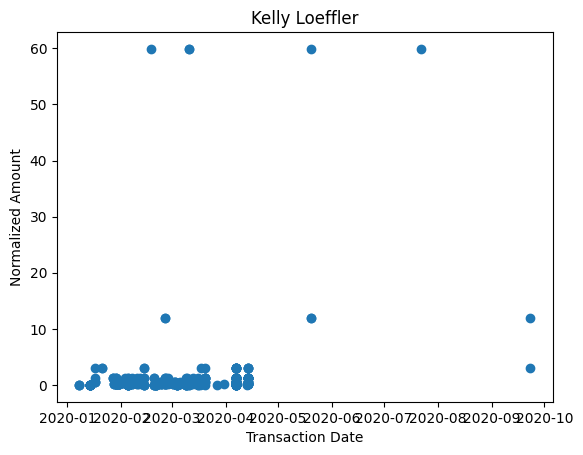

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


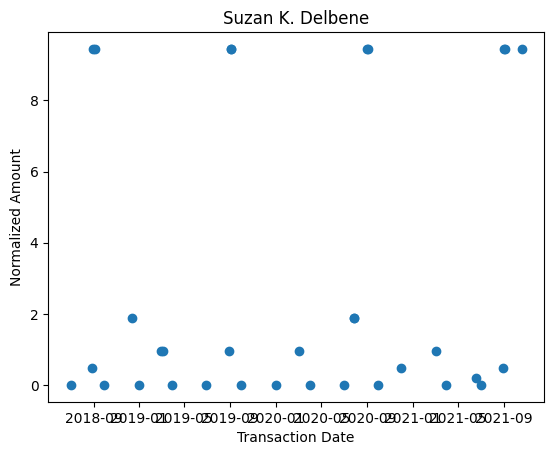

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


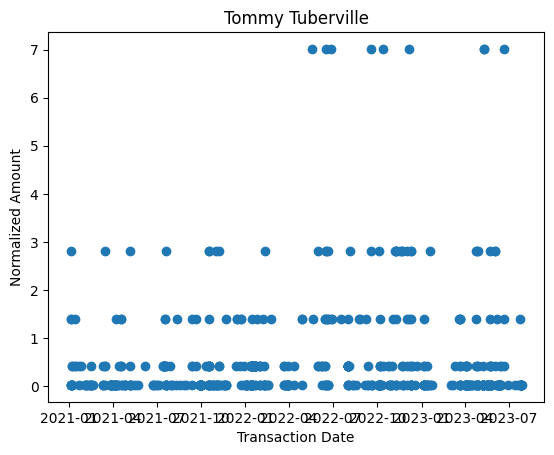

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


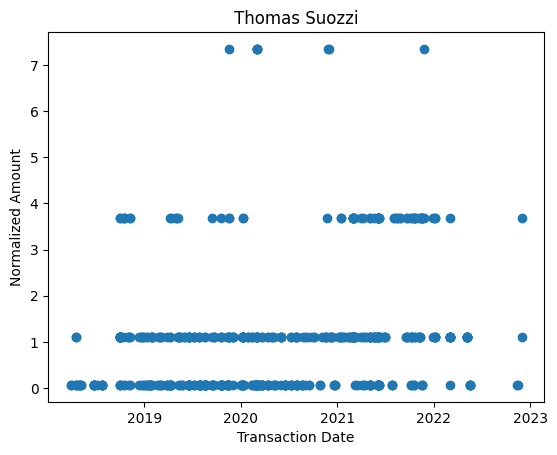

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


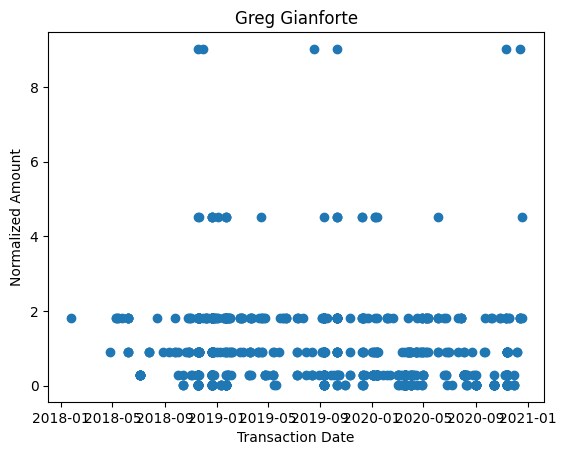

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


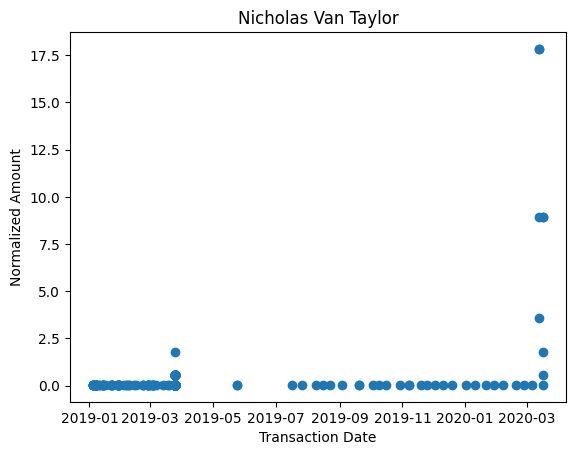

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


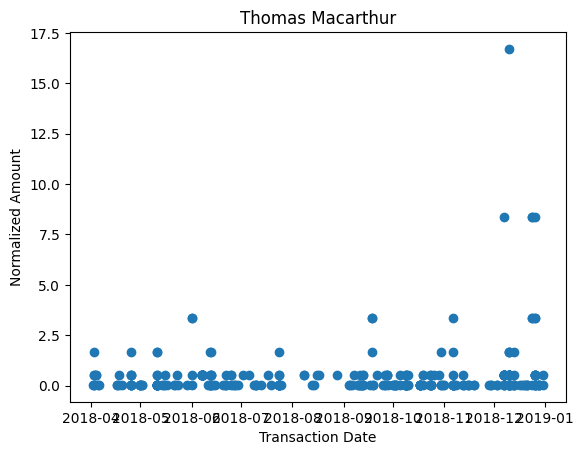

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


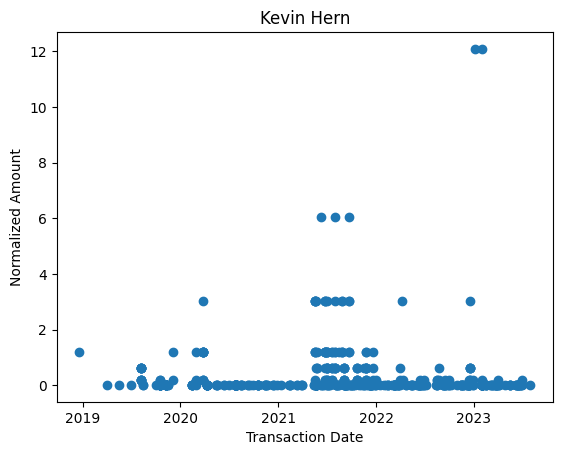

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


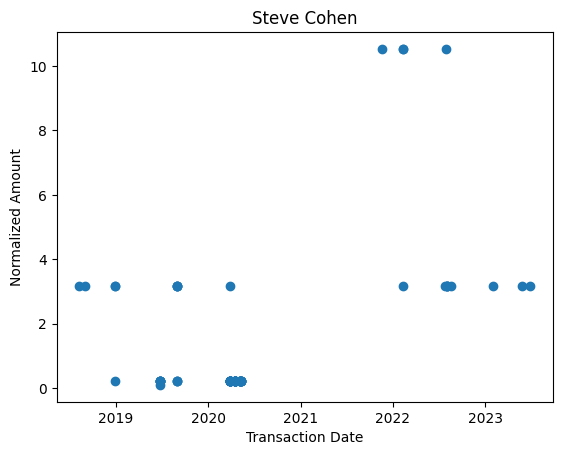

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


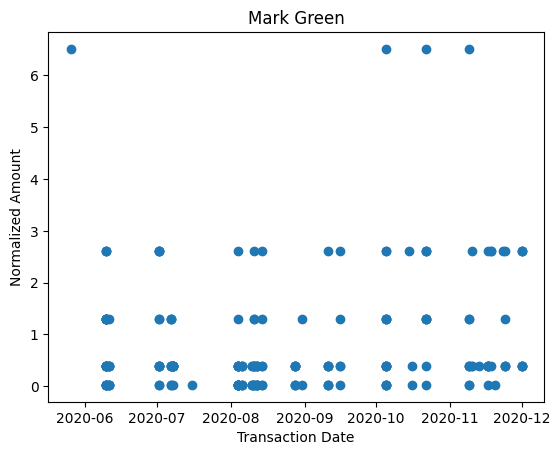

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


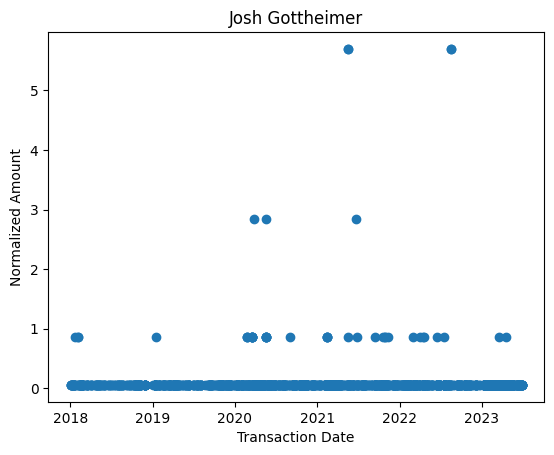

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


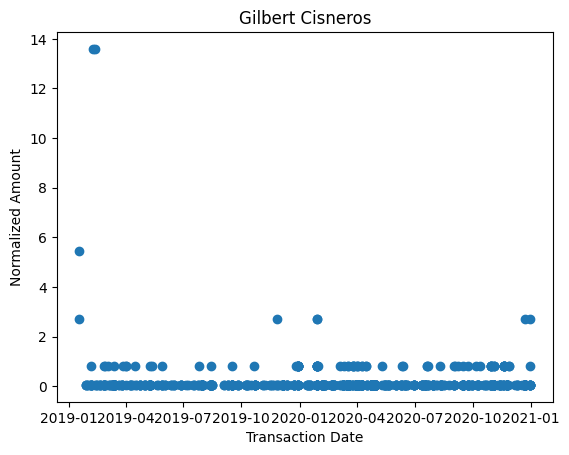

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


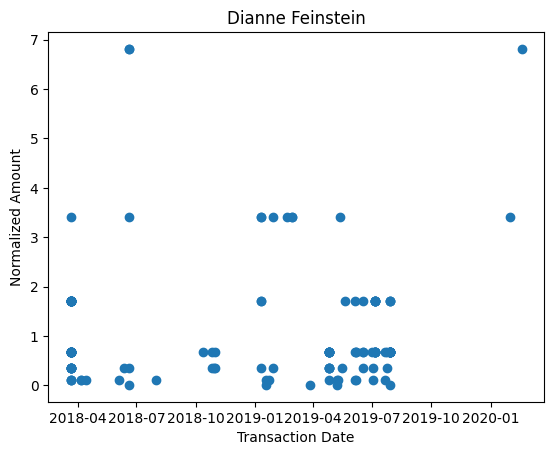

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


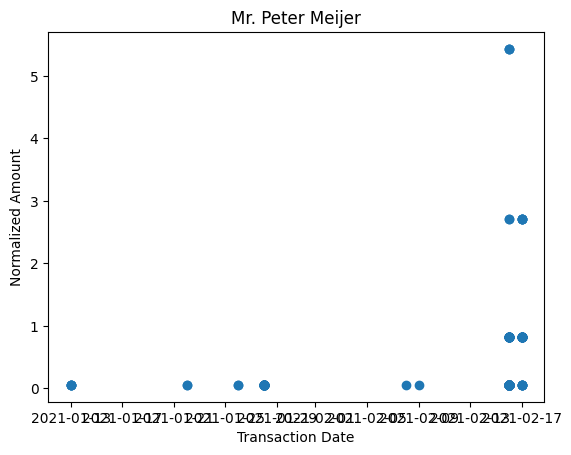

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


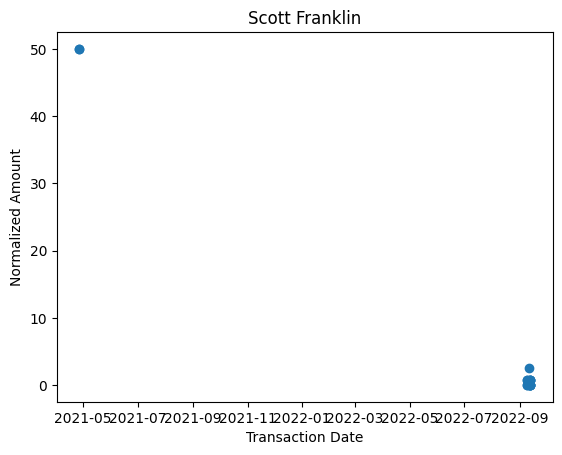

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


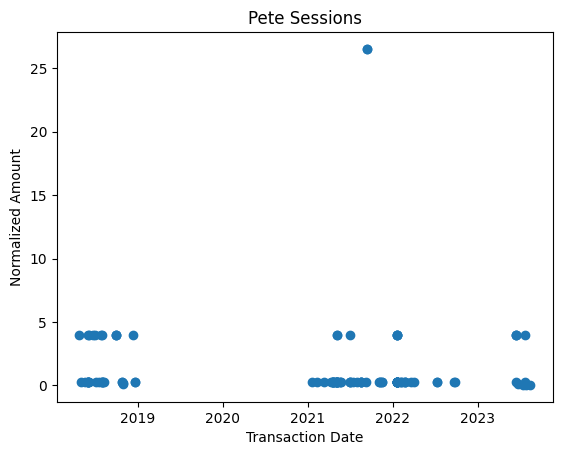

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


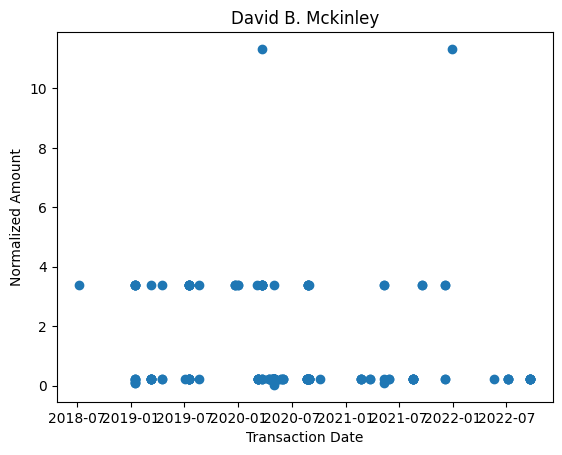

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


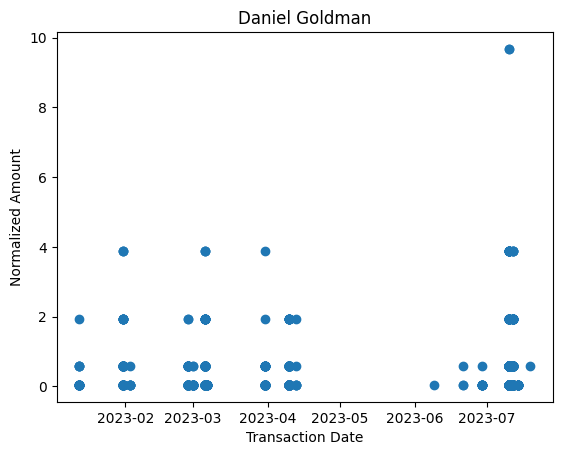

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


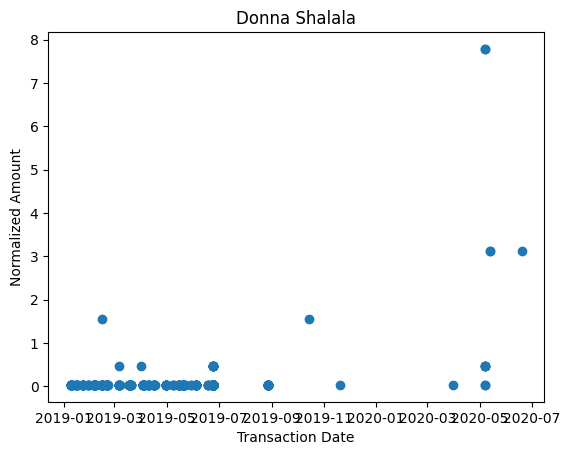

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


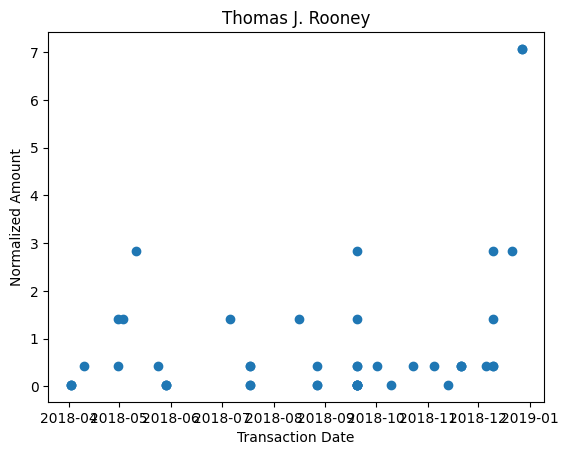

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


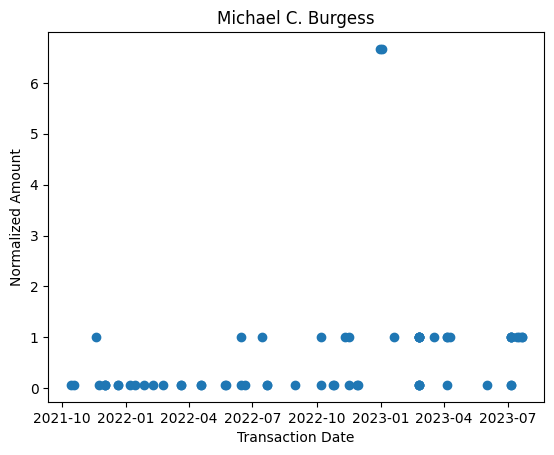

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


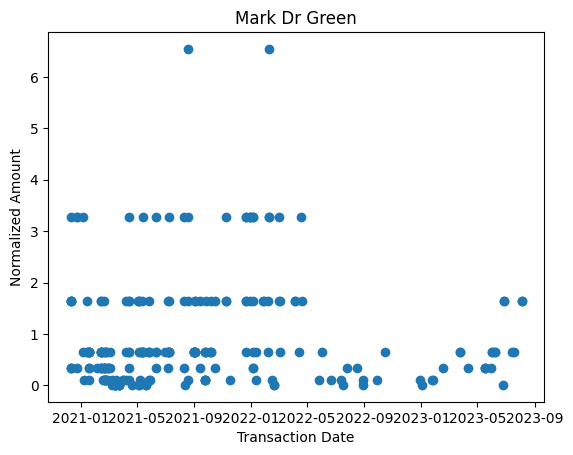

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


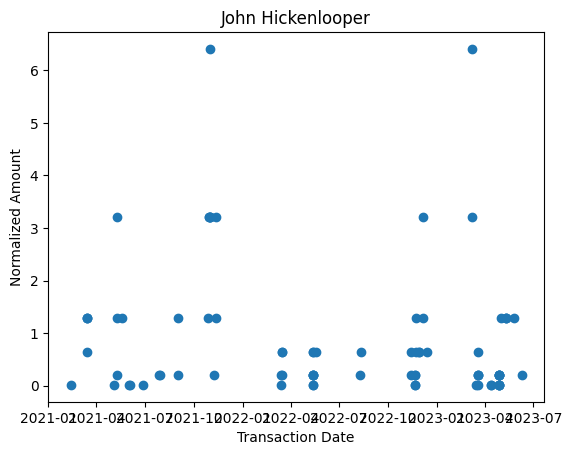

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


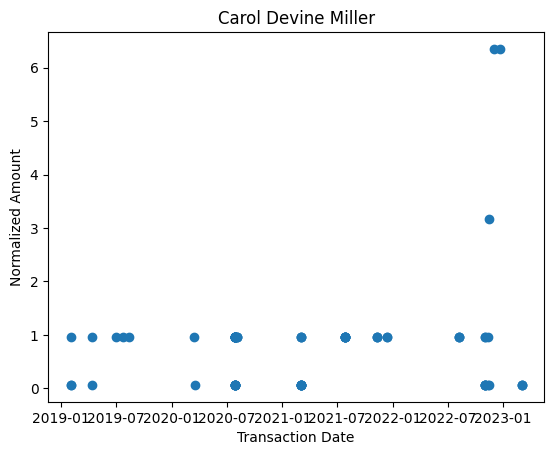

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


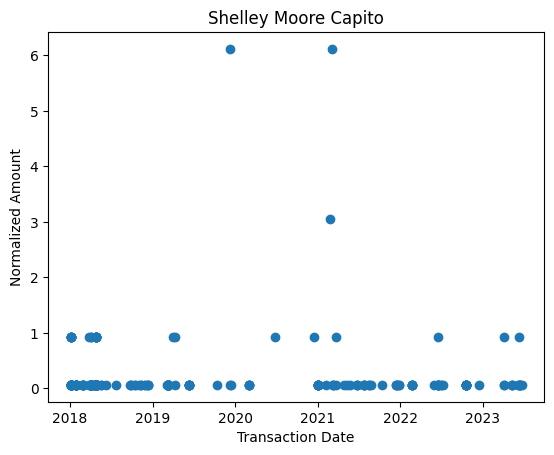

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


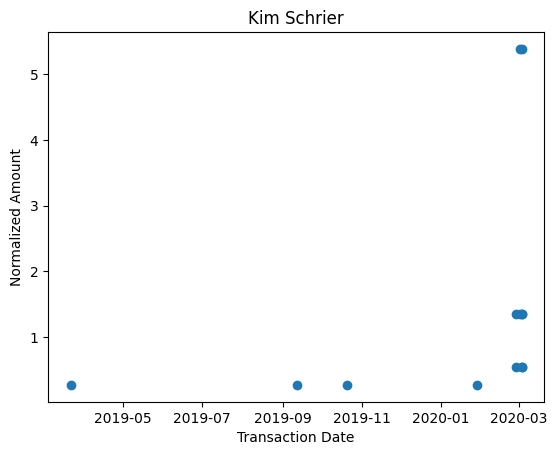

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


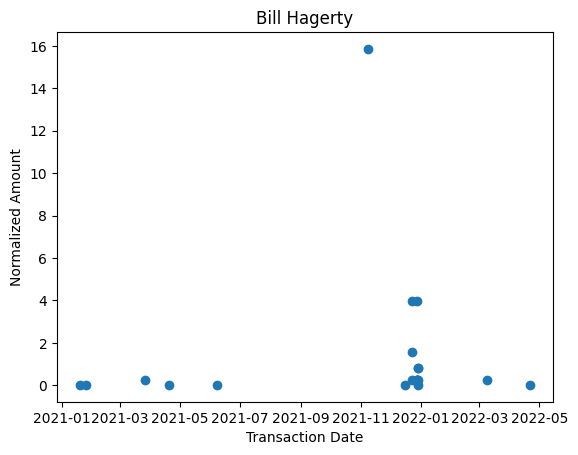

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


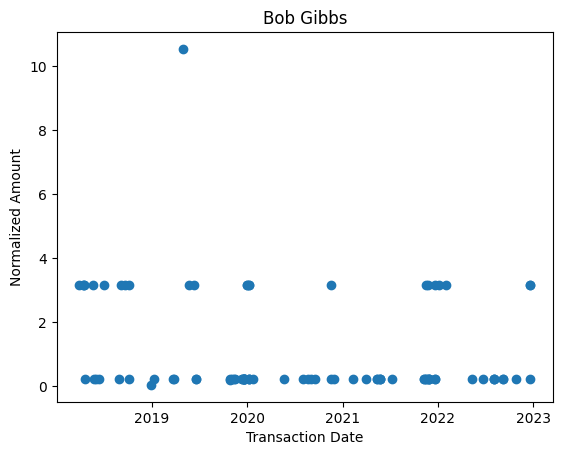

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


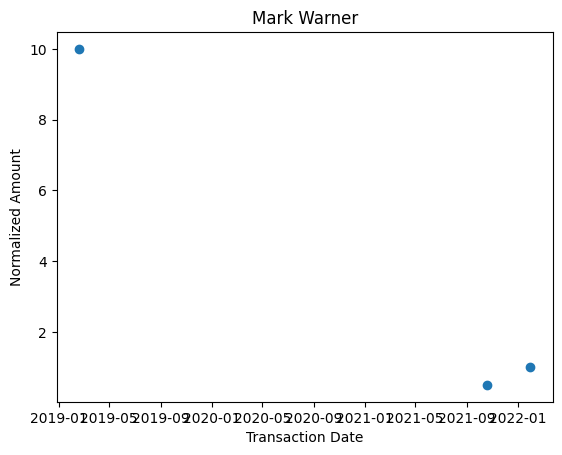

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


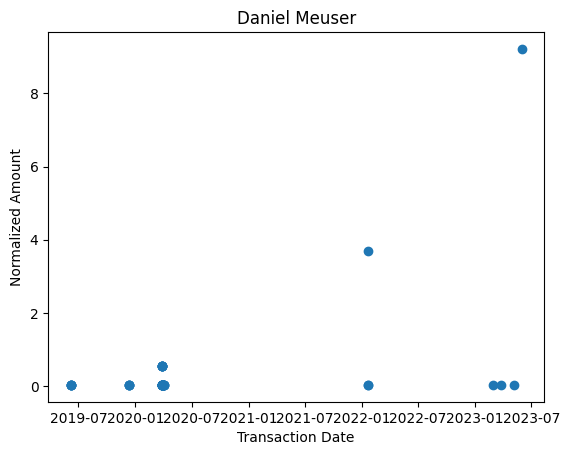

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


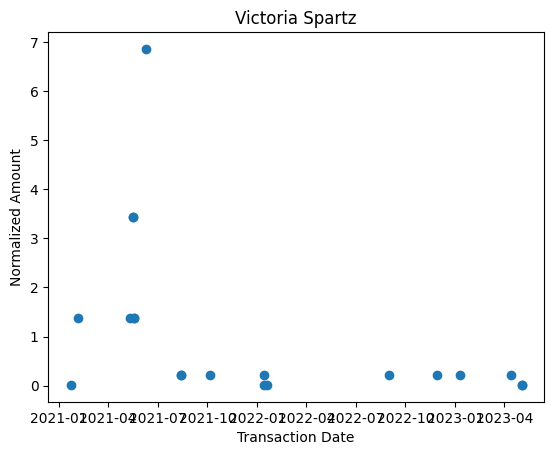

/var/folders/gy/sq_b71qx3931n7lpgb669l0w0000gq/T/ipykernel_14391/4150782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])


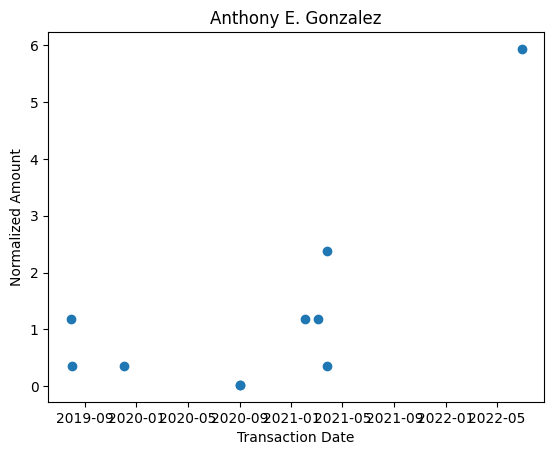

In [50]:
# for each representative in outlier_trades, plot their trades over time with normalized amount as the y axis and transactiondate in datetime as the x axis
for name, trades in outlier_trades.items():
    df_outlier = df_merged.loc[df_merged['Representative'] == name]
    df_outlier['TransactionDate'] = pd.to_datetime(df_outlier['TransactionDate'])
    df_outlier = df_outlier.sort_values(by='TransactionDate')
    plt.scatter(df_outlier['TransactionDate'], df_outlier['Normalized_Amount'])
    plt.title(f'{name}')
    plt.xlabel('Transaction Date')
    plt.ylabel('Normalized Amount')
    plt.show()

### Findings

In [56]:
# print outlier trades to show length of list for each representative
for name, trades in outlier_trades.items():
    print(f'{name}: \n\t{len(trades)} outlier trade(s)\n\t{trades}')

Alan S. Lowenthal: 
	64 outlier trade(s)
	['2020-06-29', '2022-01-21', '2020-06-04', '2021-10-21', '2019-06-04', '2022-08-26', '2018-10-29', '2022-04-06', '2019-12-13', '2022-01-14', '2022-05-06', '2022-03-07', '2021-12-15', '2021-12-15', '2022-01-14', '2019-04-15', '2021-11-04', '2018-12-03', '2020-04-03', '2018-09-24', '2022-10-21', '2020-06-04', '2020-04-03', '2020-04-03', '2020-04-03', '2018-12-03', '2020-03-20', '2020-02-19', '2020-03-09', '2018-11-20', '2019-05-23', '2018-11-29', '2021-08-23', '2019-12-11', '2021-01-27', '2021-02-25', '2019-10-08', '2021-02-01', '2020-11-09', '2021-02-22', '2021-02-22', '2018-07-20', '2021-03-10', '2020-11-09', '2018-05-04', '2020-11-23', '2021-06-03', '2020-11-23', '2022-11-04', '2018-04-27', '2021-07-08', '2020-10-28', '2020-10-15', '2020-11-09', '2021-08-23', '2020-12-28', '2019-10-31', '2022-12-09', '2019-08-20', '2021-08-23', '2021-03-15', '2020-11-10', '2020-08-06', '2019-11-04']
Susie Lee: 
	14 outlier trade(s)
	['2019-01-11', '2022-01-27'

In [64]:
# for each representative in outlier_trades, create a new dataframe that has a row for each TransactionDate, Amount, Nomrmalized_Amount, and Trimmed_Mean

# create a new dataframe that has a row for each TransactionDate, Amount, Nomrmalized_Amount, and Trimmed_Mean
dfs = []
for name, trades in outlier_trades.items():
    df_outlier = df_merged.loc[(df_merged['Representative'] == name) & (df_merged['TransactionDate'].isin(trades))]
    dfs.append(df_outlier)

df_outlier = pd.concat(dfs, ignore_index=True)
df_outlier[['Representative', 'TransactionDate', 'Amount', 'Trimmed_Mean', 'Normalized_Amount']].sort_values(by='Normalized_Amount', ascending=False)
df_outlier


,Representative,Trimmed_Mean,ReportDate,TransactionDate,Ticker,Transaction,Amount,Party,House,Range,...,Low_End,High_End,Adjusted_Low_End,Adjusted_High_End,Running_Portfolio_Low_End,Running_Portfolio_High_End,Est_Portfolio_Value,Shares_High_End,Shares_Low_End,Normalized_Amount
0,Alan S. Lowenthal,745.581138,2020-07-08,2020-06-29,SH,Purchase,15001.0,D,Representatives,15001-50000,...,15001.0,50000.0,-15001.0,-50000.0,152376.14,805000.0,478688.070,-2257.049512,-677.159995,20.119876
1,Alan S. Lowenthal,745.581138,2022-01-29,2022-01-21,HD,Sale,15001.0,D,Representatives,15001-50000,...,15001.0,50000.0,15001.0,50000.0,217229.09,1490000.0,853614.545,149.907973,44.975390,20.119876
2,Alan S. Lowenthal,745.581138,2020-06-12,2020-06-04,CRM,Purchase,15001.0,D,Representatives,15001-50000,...,15001.0,50000.0,-15001.0,-50000.0,154442.80,750000.0,452221.400,-291.647219,-87.499999,20.119876
3,Alan S. Lowenthal,745.581138,2021-11-08,2021-10-21,BX,Sale,15001.0,D,Representatives,15001-50000,...,15001.0,50000.0,15001.0,50000.0,179219.09,1270000.0,724609.545,408.484047,122.553384,20.119876
4,Alan S. Lowenthal,745.581138,2019-06-12,2019-06-04,APD,Sale,15001.0,D,Representatives,15001-50000,...,15001.0,50000.0,15001.0,50000.0,129368.70,885000.0,507184.350,257.584001,77.280352,20.119876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,Bob Gibbs,4744.446744,2019-05-03,2019-04-29,BA,Sale,50001.0,R,Representatives,50001-100000,...,50001.0,100000.0,50001.0,100000.0,56151.65,15000.0,35575.825,270.144669,135.075036,10.538847
1268,Mark Warner,100001.000000,2019-03-08,2019-02-19,CHTR,Sale,1000001.0,D,Senate,1000001 - 5000000,...,1000001.0,5000000.0,1000001.0,5000000.0,3250005.00,12500000.0,7875002.500,14350.084966,2870.019863,9.999910
1269,Daniel Meuser,27143.857143,2023-06-26,2023-05-31,NVDA,Sale,250001.0,R,Representatives,250001-1000000,...,250001.0,1000000.0,250001.0,1000000.0,265001.00,1025000.0,645000.500,2643.398820,660.852348,9.210224
1270,Victoria Spartz,72858.142857,2021-06-20,2021-06-10,SPG,Purchase,500001.0,R,Representatives,500001,...,500001.0,NaN,-500001.0,NaN,199002.00,NaN,NaN,NaN,-4207.469315,6.862665


In [ ]:
df_outlier.to_csv('trimmed_mean_outliers.csv', index=False)